![banner cnns ppgcc ufsc](../banner.png)

<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/04.3.Filtros%20Bilaterais%20e%20Anisotr%C3%B3picos.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

### Configurações GPU e PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

# 04.3.Filtros Bilaterais


**Bilateral Filtering** (BF) is a filter that acts similarly to the *Anisotropic Diffusion Filter* (ADF), blurring plateaus in the gradient landscape (regions where the image does not change much), while maintaining differences where the gradients are high. It takes one Gaussian filter in space and one more Gaussian filter which is a function of pixel difference. It is faster than an ADF, but its results are not so good. As does the ADF, the BF can be used to perform a pre-segmentation to an image, leaving it better to segment afterwards.

The Gaussian function of space makes sure that only nearby pixels are considered for blurring,  while the Gaussian function of intensity difference makes sure that only those pixels with  similar intensities to the central pixel are considered for blurring.  

So it preserves the edges since pixels at edges will have large intensity variation.

Related works:
https://www.researchgate.net/publication/262567850_Nova_metodologia_para_a_estimativa_da_cobertura_de_nuvens

In [1]:
# Import standard libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from PIL import Image
from ipywidgets import interact_manual

The Bilateral filter is composed by two filters: a spatial domaine filter that is a plain gaussian filter, and a value domain filter called as range filter. The *range filter* concerns to preserve the image edges by attributing very low-weights for neighbors that have distant colors from the centered pixel.

## Spatial filter and building a gaussian kernel

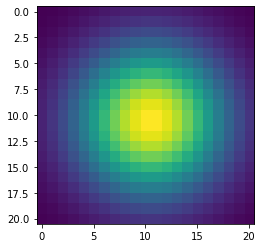

In [2]:

def get_gauss_sample(pos, mean=0, std=1):
    return np.exp(-(pos - mean)**2 / (2 * std**2))


std = 5
ks = 21
mean = ks/2

kernel = np.zeros((ks, ks))
for i in range(0, ks):
    for j in range(0, ks):
        kernel[i, j] = get_gauss_sample(pos=i, mean=mean, std=std)
        kernel[i, j] *= get_gauss_sample(pos=j, mean=mean, std=std)
        
kernel /= kernel.sum()
      
plt.imshow(kernel)

std: 1	 peak value: 0.124
std: 3	 peak value: 0.017
std: 5	 peak value: 0.006
std: 11	 peak value: 0.002


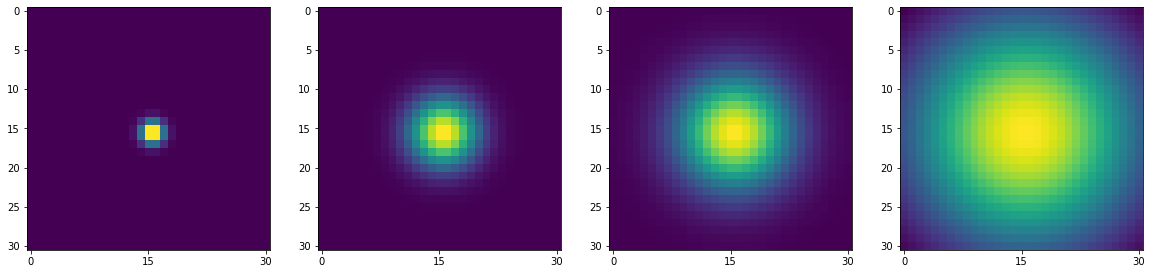

In [3]:
def get_kernel(ks, std=1):
    mean = ks/2
    kernel = np.zeros((ks, ks))
    for i in range(0, ks):
        for j in range(0, ks):
            kernel[i, j] = get_gauss_sample(pos=i, mean=mean, std=std)
            kernel[i, j] *= get_gauss_sample(pos=j, mean=mean, std=std)
    
    kernel /= kernel.sum()
    return kernel
        


standard_deviations = [1, 3, 5, 11]
ks = 31

plt.figure(figsize=(20, 8))
for i, std in enumerate(standard_deviations, 1):
    plt.subplot(eval(f'14{i}'))
    kernel = get_kernel(ks=ks, std=std)
    plt.imshow(kernel)
    print(f'std: {std}\t peak value: {kernel.max():.3f}')
#     plt.imshow(kernel, cmap='gray', vmin=0, vmax=.2)
    plt.xticks([0, (ks-1)//2, ks-1])

## Color distance filter

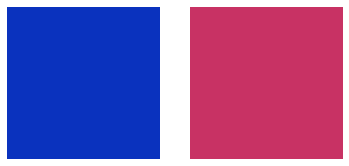

In [4]:
pixel1 = np.array([[[10, 50, 190]]])
pixel2 = np.array([[[200, 50, 100]]])

plt.subplot(121)
plt.imshow(pixel1)
plt.axis('off');
plt.subplot(122)
plt.imshow(pixel2)
plt.axis('off');

In [5]:
# Distancia euclidiana entre os pixels
dist = ((pixel2 - pixel1)**2).sum()**.5
dist

210.23796041628637

## Filtragem One-Shot

In [6]:
# Carregar imagem de nuvens via OpenCV BGR
# filename = '2021-03-31-16-24.jpg'
# filename = '2021-03-31-15-10.jpg'
filename = '2021-03-31-14-57.jpg'

im = cv2.imread('../data/nuvens/' + filename)
# Transformar em RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [7]:
# Convert it to a friendly size
newh = 512
h, w = im.shape[:2]
neww = int(w*newh/h + .5)
im = cv2.resize(im, (neww, newh))

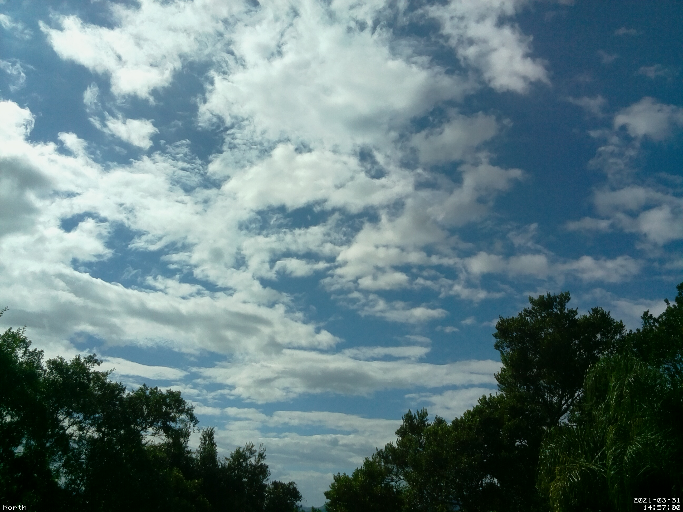

In [8]:
Image.fromarray(im)

In [9]:
??cv2.bilateralFilter

Docstring:
bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]]) -> dst
.   @brief Applies the bilateral filter to an image.
.   
.   The function applies bilateral filtering to the input image, as described in
.   http://www.dai.ed.ac.uk/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html
.   bilateralFilter can reduce unwanted noise very well while keeping edges fairly sharp. However, it is
.   very slow compared to most filters.
.   
.   _Sigma values_: For simplicity, you can set the 2 sigma values to be the same. If they are small (\<
.   10), the filter will not have much effect, whereas if they are large (\> 150), they will have a very
.   strong effect, making the image look "cartoonish".
.   
.   _Filter size_: Large filters (d \> 5) are very slow, so it is recommended to use d=5 for real-time
.   applications, and perhaps d=9 for offline applications that need heavy noise filtering.
.   
.   This filter does not work inplace.
.   @param src Source 8-bit or

In [10]:
ks = 17
std_space = 5
std_color = 50

out = cv2.bilateralFilter(im, ks, std_color, std_space)

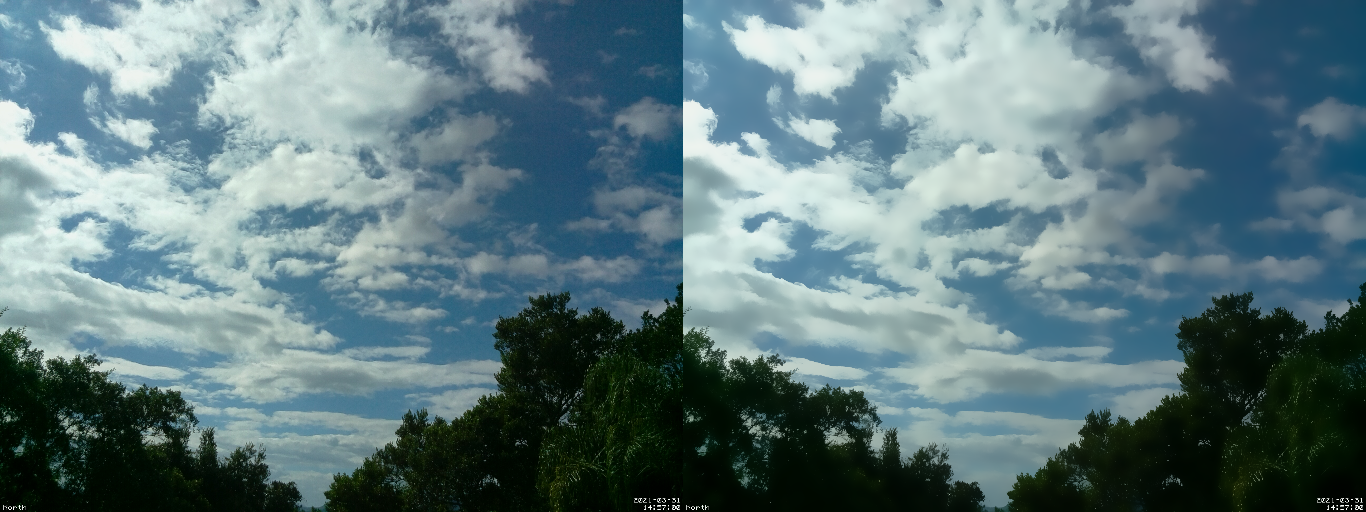

In [11]:
tmp = [im, out]
tmp = np.concatenate(tmp, axis=1)
Image.fromarray(tmp)

In [12]:

def test_bilateral_params(ks, std_space, std_color):
    out = cv2.bilateralFilter(im, ks, std_color, std_space)
    tmp = [im, out]
    tmp = np.concatenate(tmp, axis=1)
    return Image.fromarray(tmp)


interact_manual(
    test_bilateral_params,
    ks=(5, 31, 3),
    std_space=(3, 21, 1),
    std_color=(5, 100, 5)
);

interactive(children=(IntSlider(value=17, description='ks', max=31, min=5, step=3), IntSlider(value=12, descri…

## Filtragem iterativa

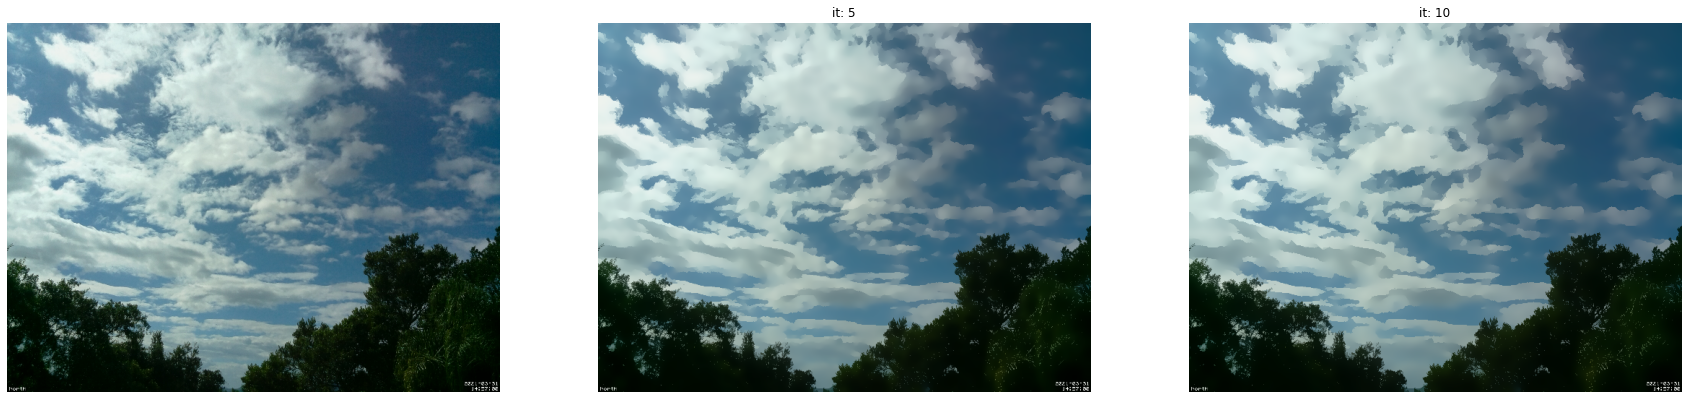

In [13]:
ks = 9
std_space = 5
std_color = 20

niters = 10

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(im)
plt.axis('off')
i_plot = 2

out = im.copy()
for it in range(niters):
    
    out = cv2.bilateralFilter(out, ks, std_color, std_space)
    
    if it in [(niters-1) // 2,  niters-1]:        
        plt.subplot(1, 3, i_plot);
        plt.imshow(out)
        plt.title(f'it: {it+1}')
        plt.axis('off')
        i_plot += 1


final1 = out.copy()    

## Filtragem iterativa raio crescente

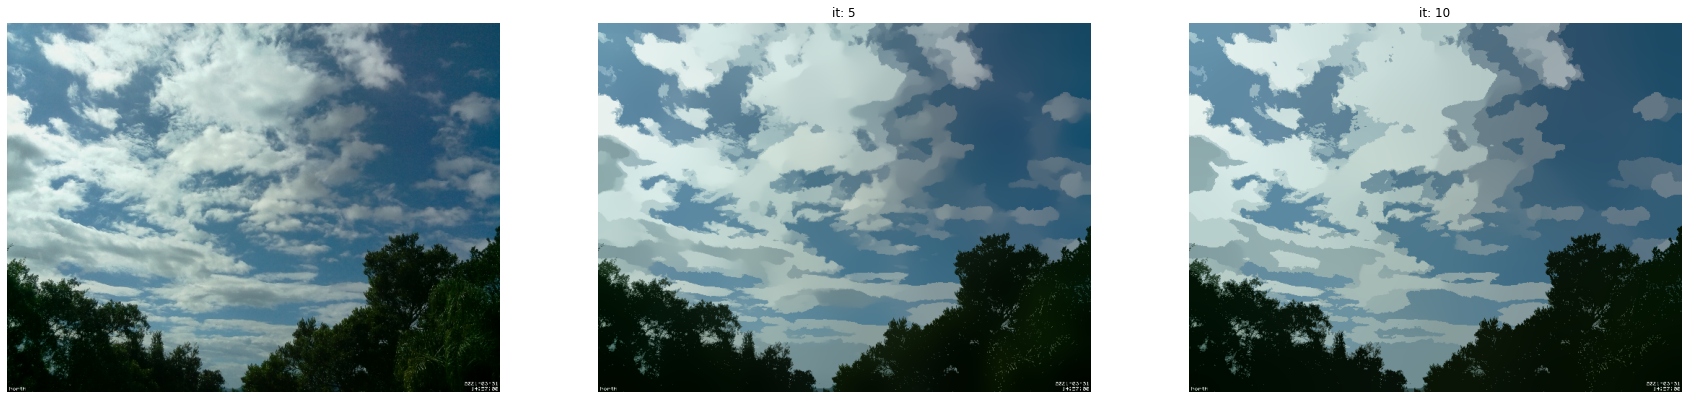

In [14]:
ks = 9
std_space = 5
std_color = 20

niters = 10

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(im)
plt.axis('off')
i_plot = 2

out = im.copy()
for it in range(niters):
    
    out = cv2.bilateralFilter(out, ks*(it+1), std_color, std_space*(it+1))
    
    if it in [(niters-1) // 2,  niters-1]:        
        plt.subplot(1, 3, i_plot);
        plt.imshow(out)
        plt.title(f'it: {it+1}')
        plt.axis('off')
        i_plot += 1

        
final2 = out.copy()

## Comparing results


Left side: Just iteractive. 
Right side: Iteractive increasing kernel radius.



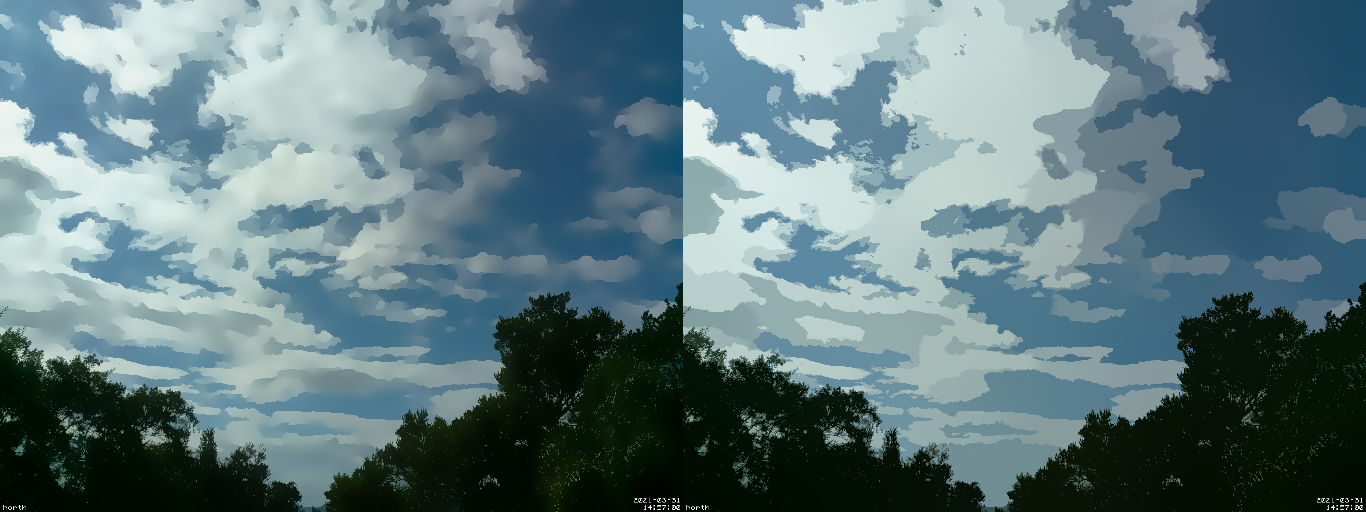

In [15]:
tmp = np.concatenate([final1, final2], axis=1)
print('\nLeft side: Just iteractive. \nRight side: Iteractive increasing kernel radius.\n')

Image.fromarray(tmp)

![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)